# TASKS
1. Data Input
2. Integration with ResNet
3. The Output of resnet to different models
4. Confidence based fusion strategy
5. Output

## Datasets tools upgrade
### One time needed

In [ ]:
# Install required packages and clone repositories
!pip install torch torchvision
!pip install prefetch_generator
!pip install pretrainedmodels
!pip install efficientnet_pytorch
!pip install timm==0.4.12  # This version includes the required module
# Clone the repositories for HybridNets#
!git clone https://github.com/datvuthanh/HybridNets.git
!pip install ultralytics
!pip install --upgrade dataset-tools

In [1]:
import tarfile
import os

# Define the path to the tar file
tar_file_path = r"/content/drive/MyDrive/ITP.tar"

# Define the extraction directory
extract_dir = "/content/extracted_data"  # You can change this

# Create the extraction directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)


try:
    # Open the tar file
    with tarfile.open(tar_file_path, "r") as tar:
        # Extract all members to the specified directory
        tar.extractall(extract_dir)
    print(f"Successfully extracted files to {extract_dir}")

except FileNotFoundError:
    print(f"Error: Tar file not found at {tar_file_path}")
except tarfile.ReadError:
    print(f"Error: Could not read the tar file. Check if it's a valid tar archive.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")


# Now you can access the extracted files in the extract_dir
# For example, to list the extracted files:
# !ls /content/extracted_data


Successfully extracted files to /content/extracted_data


In [2]:
import os
import json
import argparse
from tqdm import tqdm

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Path to the folder containing annotation JSON files
annotation_folder = "/content/extracted_data/train/ann"  # Change this to your folder path

# Set to store unique labels
unique_labels = set()

# Loop through all JSON files in the annotation folder
for filename in os.listdir(annotation_folder):
    if filename.endswith(".json"):  # Process only JSON files
        json_path = os.path.join(annotation_folder, filename)

        # Read JSON file
        with open(json_path, "r") as f:
            annotation_data = json.load(f)

        # Extract labels from objects
        for obj in annotation_data.get("objects", []):
            class_name = obj.get("classTitle", "")
            if class_name:
                unique_labels.add(class_name)  # Store unique labels

# Convert set to a sorted list
labels = sorted(list(unique_labels))

# Print the distinct labels
print("Distinct Labels in Dataset:", labels)


Distinct Labels in Dataset: ['bicycle', 'bus', 'car', 'caravan', 'motorcycle', 'pedestrian', 'rider', 'trailer', 'train', 'truck']


## Reading the Dataset

In [4]:
train_folder = '/content/extracted_data/train/img'
val_folder = '/content/extracted_data/val/img'
test_folder = '/content/extracted_data/test/img'

print('Train Folder:',len(os.listdir(train_folder)))
print('Validation Folder:',len(os.listdir(val_folder)))
print('Test Folder:', len(os.listdir(test_folder)))

Train Folder: 7000
Validation Folder: 1000
Test Folder: 2000


# Data Visualization

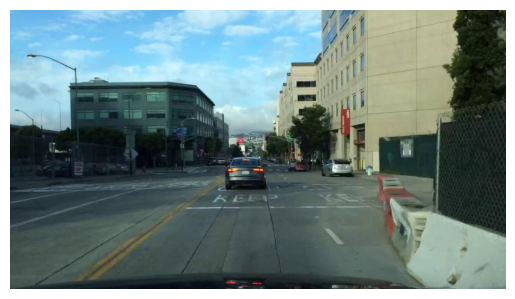

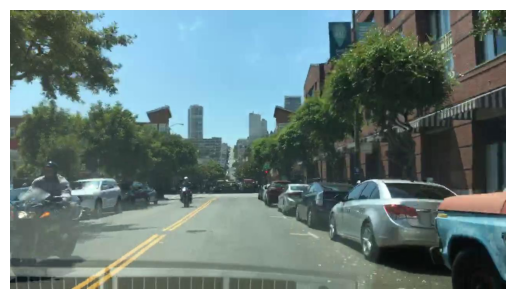

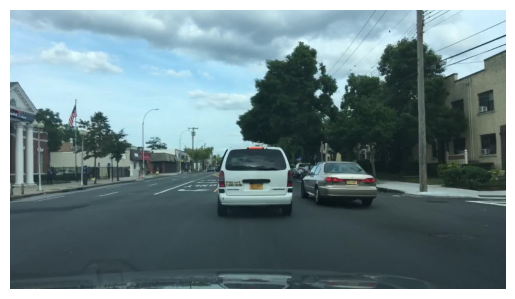

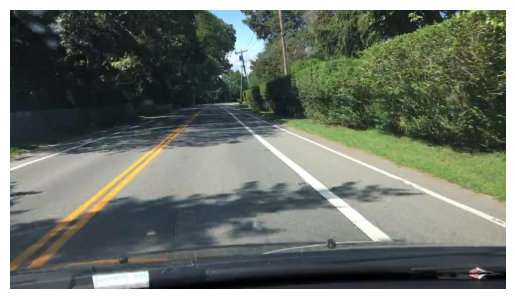

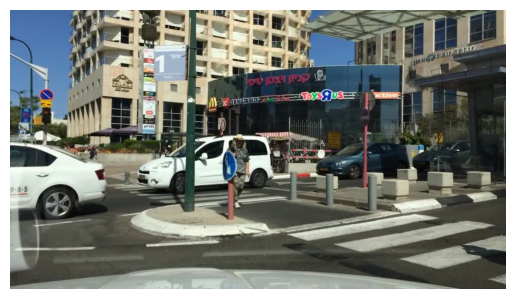

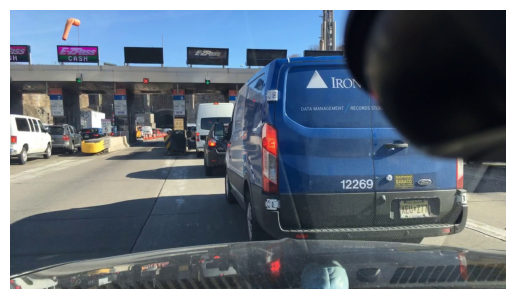

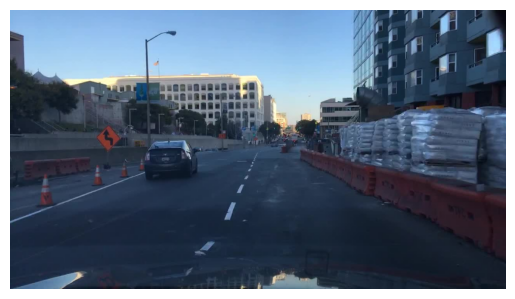

In [5]:
import matplotlib.image as mpimg
images_name = os.listdir(train_folder)
for i in range(10):
  image_path = os.path.join(train_folder, images_name[i])
  try:
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.show()
  except Exception as e:
    print(f"An error occurred: {e}")

## Image Shapes

In [6]:
images_name = os.listdir(train_folder)
for i in range(10):
  image_path = os.path.join(train_folder, images_name[i])
  try:
    img = mpimg.imread(image_path)
    print(f"Shape of image {images_name[i]}: {img.shape}")
  except Exception as e:
    print(f"An error occurred while processing {images_name[i]}: {e}")


Shape of image 7ccd7466-426b0001.jpg: (720, 1280, 3)
Shape of image 164b2a2d-78a90001.jpg: (720, 1280, 3)
Shape of image 3be2c655-c64ebcb8.jpg: (720, 1280, 3)
Shape of image 9608e62f-b627cdf4.jpg: (720, 1280, 3)
Shape of image 208be040-b7ad1b43.jpg: (720, 1280, 3)
Shape of image 456144b6-84753946.jpg: (720, 1280, 3)
Shape of image 621fb031-8e212444.jpg: (720, 1280, 3)
Shape of image 6c2ab388-58f4b8d3.jpg: (720, 1280, 3)
Shape of image 733f3ba7-6566b4f4.jpg: (720, 1280, 3)
Shape of image 87e78191-291740fc.jpg: (720, 1280, 3)


## Images and Video Path

In [7]:
def image_to_ann_path(image_path):
    return image_path.replace("/img/", "/ann/") + ".json"

image_path = input('Enter The path of image: ')
ann_path = image_to_ann_path(image_path)
video_path = input('Enter the path of Video in mp4 format: ')



Enter The path of image: /content/extracted_data/val/img/7dca6982-6971d025.jpg
Enter the path of Video in mp4 format: /content/WhatsApp Video 2025-02-23 at 21.54.15_c71e2213.mp4


## ResNet-50
### For extraction of high quality feature map which then serves as the input of Yolo + HybridNets

In [8]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import os

# Load ResNet model (e.g., ResNet-50)
resnet = models.resnet50(pretrained=True)
resnet = torch.nn.Sequential(*list(resnet.children())[:-2])  # Remove classification layers
resnet.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match ResNet input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

adaptive_pool = torch.nn.AdaptiveAvgPool2d((23, 40))  # Define target size

def extract_features_with_pooling(image_path):
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0)
    with torch.no_grad():
        features = resnet(image)
        features = adaptive_pool(features)  # Reduce to fixed size
    return features

pooled_features_stored = {}

images_name = os.listdir(train_folder)
for i in range(100):
  image_path = os.path.join(train_folder, images_name[i])
  features = extract_features_with_pooling(image_path)
  pooled_features_stored[images_name[i]] = features.numpy()


print("Code Executed Succesfully")



Code Executed Succesfully


## Implementation of Hybrid Nets

torch.Size([1, 2048, 23, 40])


Using cache found in /root/.cache/torch/hub/datvuthanh_hybridnets_main
Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth
100%|██████████| 47.1M/47.1M [00:00<00:00, 175MB/s]
Downloading: "https://github.com/datvuthanh/HybridNets/releases/download/v1.0/hybridnets.pth" to /root/.cache/torch/hub/checkpoints/hybridnets.pth
100%|██████████| 52.2M/52.2M [00:00<00:00, 140MB/s]


HybridNets model loaded successfully!
Preprocessing transform defined.
Loaded and preprocessed image: /content/extracted_data/train/img/2ce235bb-00000000.jpg
Inference completed.
Output 0 is a <class 'tuple'> with 5 elements:
   Element 0 shape: torch.Size([1, 160, 48, 80])
   Element 1 shape: torch.Size([1, 160, 24, 40])
   Element 2 shape: torch.Size([1, 160, 12, 20])
   Element 3 shape: torch.Size([1, 160, 6, 10])
   Element 4 shape: torch.Size([1, 160, 3, 5])
Output 1 shape: torch.Size([1, 46035, 4])
Output 2 shape: torch.Size([1, 46035, 1])
Output 3 shape: torch.Size([1, 46035, 4])
Output 4 shape: torch.Size([1, 3, 384, 640])
Final detection boxes (after NMS):
[[-2.59242672e-03 -7.52692744e-02 -8.37006271e-02 -1.24486282e-01]
 [ 6.28670081e-02 -1.34378262e-02  2.29950577e-01 -8.80038142e-02]
 [-5.34698367e-02  1.83726460e-01 -1.14046738e-01  2.68433154e-01]
 [-7.02913031e-02  1.07104674e-01 -3.08733135e-02 -3.45335454e-01]
 [ 4.47041914e-02 -2.00737678e-02 -2.34101862e-01  3.97836

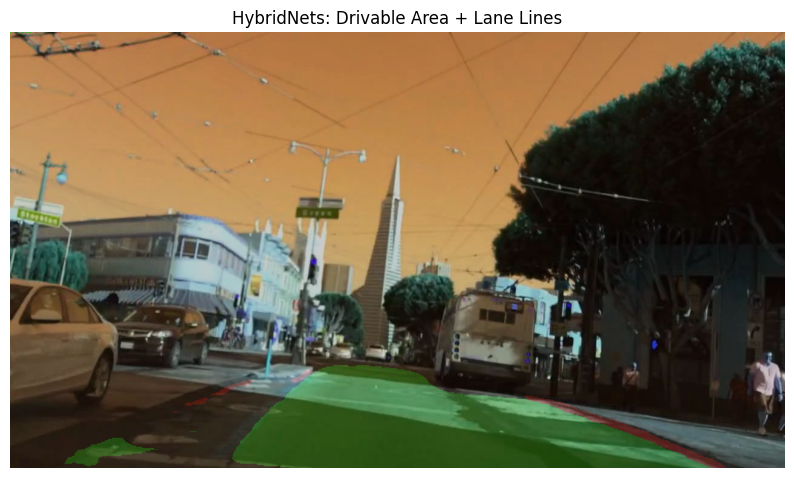

Model weights saved as 'hybridnets_weights.pth'


In [9]:
import torch
import torchvision.models as models
import torch.nn as nn

# Load ResNet50 pretrained model
resnet = models.resnet50(pretrained=True)
resnet = nn.Sequential(*list(resnet.children())[:-2])
resnet.eval()
# Test with a dummy input
dummy_input = torch.randn(1, 3, 720, 1280)
features = resnet(dummy_input)
print(features.shape)  # Output: (1, 2048, H', W')

# ----------------------------------------------------
import torch
#Load the HybridNets model from PyTorch Hub (pretrained on BDD100K)
#You can change 'pretrained=True' if you want to load custom weights later.
model = torch.hub.load('datvuthanh/hybridnets', 'hybridnets', pretrained=True)
model.eval()  # Set the model to evaluation mode
print("HybridNets model loaded successfully!")
# -------------------------------------------------------
from torchvision import transforms
# Define the transformation steps.
# Change the Resize dimensions if your testing images are of a different size.
transform = transforms.Compose([
    transforms.Resize((384, 640)),  # Change these dimensions if needed
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Standard normalization values
                         std=[0.229, 0.224, 0.225])
])

print("Preprocessing transform defined.")
#--------------------------------------------------------
## Loading and Preprocessing the images
from PIL import Image
## Image Path

# Change 'path_to_test_image.jpg' to the path of your testing image.
# If you have multiple images, you can loop over them.
  # <-- CHANGE THIS to your image path
image = Image.open(image_path).convert('RGB')

# Apply the transformation and add a batch dimension
input_tensor = transform(image).unsqueeze(0)

print(f"Loaded and preprocessed image: {image_path}")
#------------------------------------------------------------
## Inference
# Run inference on the preprocessed image without computing gradients
with torch.no_grad():
    # The model outputs several items:
    # features, regression, classification, anchors, segmentation
    features, regression, classification, anchors, segmentation = model(input_tensor)

print("Inference completed.")
#-------------------------------------------------------------
# Inspect each output from the model
outputs = [features, regression, classification, anchors, segmentation]

for i, out in enumerate(outputs):
    if hasattr(out, 'shape'):
        print(f"Output {i} shape: {out.shape}")
    elif isinstance(out, (tuple, list)):
        print(f"Output {i} is a {type(out)} with {len(out)} elements:")
        for j, sub_out in enumerate(out):
            if hasattr(sub_out, 'shape'):
                print(f"   Element {j} shape: {sub_out.shape}")
            else:
                print(f"   Element {j} type: {type(sub_out)}")
    else:
        print(f"Output {i} type: {type(out)}")

#------------------------------------------------------------
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision.ops as ops

# --------------------------
# Process Detection Outputs
# --------------------------
# For demonstration, assume:
# - Output 1 holds bounding box coordinates in (x1, y1, x2, y2).
# - Output 2 holds the confidence scores.
# You may need to adjust these assumptions based on the model documentation.

# Remove batch dimension
boxes = regression[0]       # Shape: [46035, 4]
scores = classification[0].squeeze(-1)  # Shape: [46035]; adjust if necessary

# Set a confidence threshold; change as needed.
conf_threshold = 0.5
keep_mask = scores > conf_threshold
boxes = boxes[keep_mask]
scores = scores[keep_mask]

# Apply Non-Maximum Suppression (NMS) with an IoU threshold of 0.5; adjust threshold as needed.
nms_threshold = 0.5
keep_indices = ops.nms(boxes, scores, nms_threshold)

# Final detection boxes after NMS
final_boxes = boxes[keep_indices].cpu().numpy()
final_scores = scores[keep_indices].cpu().numpy()

print("Final detection boxes (after NMS):")
print(final_boxes)
print("Scores:", final_scores)

# --------------------------
# Process Segmentation Output
# --------------------------
# For segmentation output, assume Output 4 is a set of per-pixel class scores.
# Taking argmax along the channel dimension gives the predicted class for each pixel.
seg_map = segmentation[0]  # Shape: [3, 384, 640]
seg_labels = torch.argmax(seg_map, dim=0).cpu().numpy()  # Resulting shape: [384, 640]
# --------------------------
# Note:
# - You will need to integrate these post-processing steps with your own code
#   depending on your specific requirements (e.g., drawing boxes on the image).
# - The assumptions on outputs (which output represents what) may need to be confirmed
#   with the HybridNets documentation or by inspecting the model code.
#----------------------------------------------------------------------------------------
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision import ops
from PIL import Image

# -----------------------------------------------------------------------------
# ASSUMPTIONS:
#   - 'image_path' is your original image file (at full resolution or same as model input).
#   - 'model' is the HybridNets model, already loaded and in eval mode.
#   - 'input_tensor' is the preprocessed tensor you used for inference.
#   - 'regression', 'classification', 'segmentation' are the model outputs.
# -----------------------------------------------------------------------------

# -----------------------------
# 1) Load Original Image
# -----------------------------
original_image_pil = Image.open(image_path).convert('RGB')
original_image = np.array(original_image_pil)  # shape: [H, W, 3] in RGB

# If your original image was resized before inference (e.g., 384x640),
# keep track of that scale to map boxes back. Example:
model_input_height, model_input_width = input_tensor.shape[2], input_tensor.shape[3]
orig_height, orig_width = original_image.shape[:2]

# Scale factors if needed
scale_y = orig_height / model_input_height
scale_x = orig_width / model_input_width

# -----------------------------
# 2) Post-Process Detection
# -----------------------------
# 'regression' shape: [batch, num_anchors, 4]
# 'classification' shape: [batch, num_anchors, 1] (or similar)
boxes = regression[0]           # [num_anchors, 4]
scores = classification[0].squeeze(-1)  # [num_anchors]

# Confidence threshold
conf_threshold = 0.5
mask = scores > conf_threshold
boxes = boxes[mask]
scores = scores[mask]

# Non-Max Suppression
nms_threshold = 0.3
keep_indices = ops.nms(boxes, scores, nms_threshold)
boxes = boxes[keep_indices].cpu().numpy()
scores = scores[keep_indices].cpu().numpy()

# Draw bounding boxes on original_image
for i, box in enumerate(boxes):
    x1, y1, x2, y2 = box
    # If you resized input for the model, rescale box coords to original_image
    x1 *= scale_x
    x2 *= scale_x
    y1 *= scale_y
    y2 *= scale_y

    # Round coords and convert to int
    x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])

    # Draw rectangle
    cv2.rectangle(
        original_image, (x1, y1), (x2, y2),
        color=(0, 255, 0),  # BGR green
        thickness=2
    )
    # Optionally put a label or score
    label = f"{scores[i]:.2f}"
    cv2.putText(
        original_image, label, (x1, max(y1 - 5, 0)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5,
        color=(0, 255, 0), thickness=1
    )

# -----------------------------
# 3) Post-Process Segmentation
# -----------------------------
# 'segmentation' shape: [batch, num_classes, H, W]
seg_map = segmentation[0]  # shape: [num_classes, H, W]
seg_labels = torch.argmax(seg_map, dim=0).cpu().numpy()  # shape: [H, W]

# If needed, resize seg_labels back to original_image size
# e.g., if model input was 384x640, and original is 1080x1920, do:
seg_labels_resized = cv2.resize(seg_labels.astype(np.uint8),
                                (orig_width, orig_height),
                                interpolation=cv2.INTER_NEAREST)

# Create a color overlay
# Let's assume:
#   0 = background
#   1 = drivable area
#   2 = lane lines
# You can add more classes or different colors if needed.
overlay = np.zeros_like(original_image, dtype=np.uint8)

# Define BGR colors for each label
# (0=background, 1=green, 2=red, etc.)
color_map = {
    0: (0, 0, 0),      # background -> black (no overlay)
    1: (0, 255, 0),    # drivable area -> green
    2: (0, 0, 255),    # lane lines -> red
}

# Paint overlay
for label_val, color in color_map.items():
    mask = seg_labels_resized == label_val
    overlay[mask] = color

# Blend overlay with the original image
alpha = 0.2  # transparency factor
blended = cv2.addWeighted(original_image, 1 - alpha, overlay, alpha, 0)

# -----------------------------
# 4) Display the Final Result
# -----------------------------
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(blended, cv2.COLOR_BGR2RGB))  # Convert BGR->RGB for plotting
plt.title("HybridNets: Drivable Area + Lane Lines")
plt.axis('off')
plt.show()
# Save the model weights to a file
torch.save(model.state_dict(), "hybridnets_weights.pth")
print("Model weights saved as 'hybridnets_weights.pth'")

## Desicion Fuser - Fusion of Yolo and Hybrid Nets models

In [10]:
import cv2
import torch
import numpy as np
from ultralytics import YOLO
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

# -------------------------------
# 1. Load Models
# -------------------------------

# YOLO Model (for object detection)
yolo = YOLO('yolo11s.pt')  # Ensure the model file path is correct

# HybridNets Model (for segmentation and detection)
hybrid_model = torch.hub.load('datvuthanh/hybridnets', 'hybridnets', pretrained=True)
hybrid_model.eval()

# Define transformation for HybridNets (input size set to 384x640)
hybrid_transform = transforms.Compose([
    transforms.Resize((384, 640)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# -------------------------------
# 2. Utility Function for Colors
# -------------------------------

def getColours(cls_num):
    base_colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]
    color_index = cls_num % len(base_colors)
    increments = [(1, -2, 1), (-2, 1, -1), (1, -1, 2)]
    color = [
        (base_colors[color_index][i] + increments[color_index][i] * (cls_num // len(base_colors))) % 256
        for i in range(3)
    ]
    return tuple(color)

# -------------------------------
# 3. Load and Prepare the Image
# -------------------------------

# Specify the image path

frame = cv2.imread(image_path)
if frame is None:
    raise ValueError("Error loading image. Check the file path.")

# Make a copy for drawing YOLO detections
yolo_output = frame.copy()

# -------------------------------
# 4. Run YOLO for Object Detection
# -------------------------------

# For a single image, use YOLO's default inference method
yolo_results = yolo(frame)

# Loop over each result (typically only one for a single image)
for result in yolo_results:
    class_names = result.names  # Dictionary mapping class indices to names
    for box in result.boxes:
        # Filter out weak detections
        if box.conf[0] > 0.4:
            # Get bounding box coordinates
            [x1, y1, x2, y2] = box.xyxy[0]
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
            cls = int(box.cls[0])
            class_name = class_names[cls]
            colour = getColours(cls)
            # Draw the rectangle and label on the copy of the image
            cv2.rectangle(yolo_output, (x1, y1), (x2, y2), colour, 2)
            cv2.putText(yolo_output, f'{class_name} {box.conf[0]:.2f}',
                        (x1, max(y1-10, 0)), cv2.FONT_HERSHEY_SIMPLEX, 0.9, colour, 2)

# -------------------------------
# 5. Run HybridNets for Segmentation
# -------------------------------

# Convert the image from BGR (cv2) to RGB (PIL) format
image_pil = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
input_tensor = hybrid_transform(image_pil).unsqueeze(0)  # Add batch dimension

with torch.no_grad():
    _, regression, classification, anchors, segmentation = hybrid_model(input_tensor)

# Process the segmentation output:
# segmentation is expected to be of shape [batch, num_classes, H, W]
seg_map = segmentation[0]  # Remove batch dimension
# Get per-pixel predicted class by taking the argmax over the channels
seg_labels = torch.argmax(seg_map, dim=0).cpu().numpy()

# Define a simple color mapping for segmentation classes:
color_map = {
    0: (0, 0, 0),       # background: black (transparent)
    1: (0, 255, 0),     # drivable area: green
    2: (0, 0, 255)      # lane lines: red
}
# Create a blank overlay image
overlay = np.zeros((seg_labels.shape[0], seg_labels.shape[1], 3), dtype=np.uint8)
for cls_id, color in color_map.items():
    overlay[seg_labels == cls_id] = color

# Resize the segmentation overlay to match the original image dimensions
overlay_resized = cv2.resize(overlay, (frame.shape[1], frame.shape[0]), interpolation=cv2.INTER_NEAREST)

# -------------------------------
# 6. Merge YOLO and HybridNets Outputs
# -------------------------------

# Blend the YOLO detections (with bounding boxes) and the segmentation overlay
alpha = 0.4  # Transparency factor for the segmentation overlay
merged_output = cv2.addWeighted(yolo_output, 1 - alpha, overlay_resized, alpha, 0)

# -------------------------------
# 7. Display the Merged Output using Matplotlib
# -------------------------------

plt.figure(figsize=(12, 8))
# Convert BGR image to RGB for display with matplotlib
plt.imshow(cv2.cvtColor(merged_output, cv2.COLOR_BGR2RGB))
plt.title("Merged YOLO & HybridNets Output")
plt.axis('off')
plt.show()


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 18.4M/18.4M [00:00<00:00, 146MB/s]
Using cache found in /root/.cache/torch/hub/datvuthanh_hybridnets_main



0: 384x640 4 persons, 4 cars, 1 bus, 2 traffic lights, 329.1ms
Speed: 4.2ms preprocess, 329.1ms inference, 9.5ms postprocess per image at shape (1, 3, 384, 640)


## Ground Truth

JSON Keys: dict_keys(['description', 'tags', 'size', 'objects'])
First object keys: dict_keys(['id', 'classId', 'description', 'geometryType', 'labelerLogin', 'createdAt', 'updatedAt', 'tags', 'classTitle', 'points'])


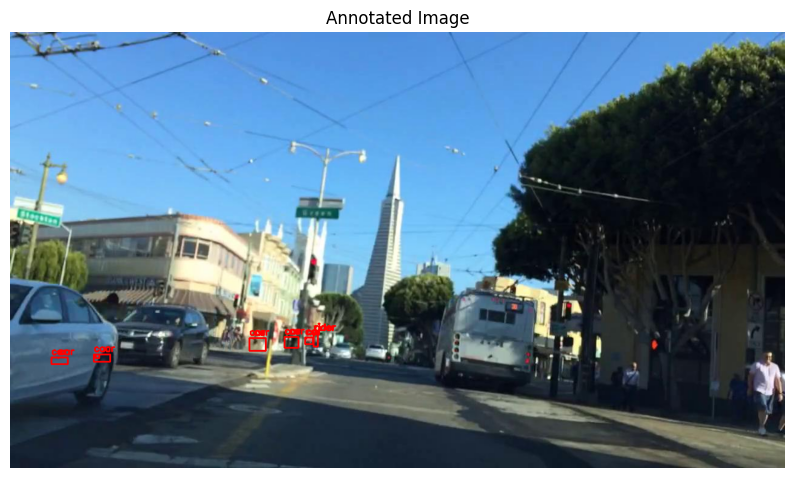

In [11]:
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load image
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB for Matplotlib

# Load annotation file
annotation_path = ann_path
with open(annotation_path, "r") as f:
    annotations = json.load(f)

# Debugging: Print the keys to verify structure
print("JSON Keys:", annotations.keys())

# Extract objects from annotations
objects = annotations.get("objects", [])
if not objects:
    print("No objects found in annotation file.")
else:
    print("First object keys:", objects[0].keys())

# Draw bounding boxes and segmentation masks
for obj in objects:
    label = obj.get("classTitle", "Unknown")  # Use classTitle instead of category

    if "points" in obj and "exterior" in obj["points"]:
        # Extract bounding box coordinates
        x1, y1 = map(int, obj["points"]["exterior"][0])  # Top-left corner
        x2, y2 = map(int, obj["points"]["exterior"][1])  # Bottom-right corner

        # Draw bounding box
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
        cv2.putText(image, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

# Display the annotated image
plt.figure(figsize=(10, 6))
plt.imshow(image)
plt.axis("off")
plt.title("Annotated Image")
plt.show()


## Framewise Analysis of Video in Notebook

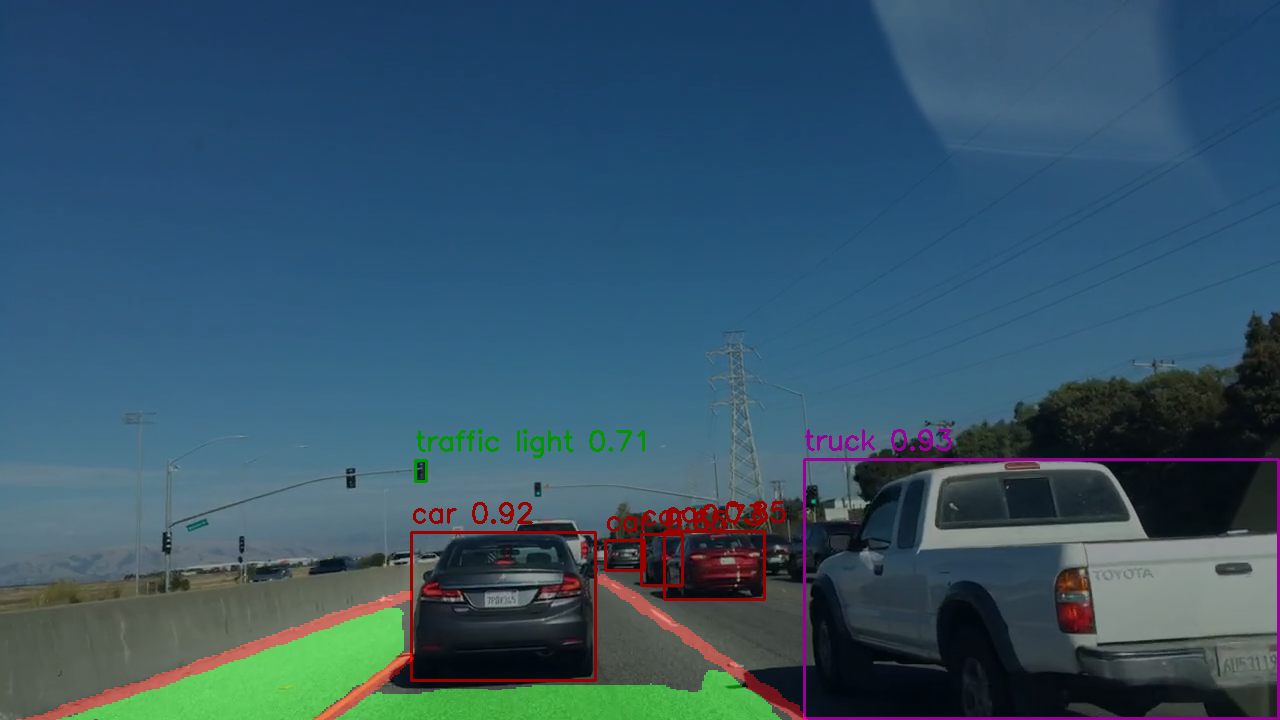


0: 384x640 7 cars, 2 trucks, 3 traffic lights, 514.4ms
Speed: 3.4ms preprocess, 514.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


In [ ]:
import cv2
import torch
import numpy as np
import time
from ultralytics import YOLO
from torchvision import transforms
from PIL import Image
from google.colab.patches import cv2_imshow
from IPython.display import clear_output

# -----------------------------------------------------------
# 1. Load Models
# -----------------------------------------------------------
# Load YOLO model (update the path if needed)
yolo = YOLO('yolo11s.pt')
print("YOLO model loaded successfully!")

# Load HybridNets model from PyTorch Hub (pretrained on BDD100K)
hybrid_model = torch.hub.load('datvuthanh/hybridnets', 'hybridnets', pretrained=True)
hybrid_model.eval()  # Set model to evaluation mode
print("HybridNets model loaded successfully!")

# -----------------------------------------------------------
# 2. Define Preprocessing Transform for HybridNets
# -----------------------------------------------------------
transform = transforms.Compose([
    transforms.Resize((384, 640)),  # Adjust dimensions if needed
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
print("Preprocessing transform defined.")

# -----------------------------------------------------------
# 3. Utility Function for YOLO Colors
# -----------------------------------------------------------
def getColours(cls_num):
    base_colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]
    color_index = cls_num % len(base_colors)
    increments = [(1, -2, 1), (-2, 1, -1), (1, -1, 2)]
    color = [ (base_colors[color_index][i] + increments[color_index][i] * (cls_num // len(base_colors))) % 256 for i in range(3)]
    return tuple(color)

# -----------------------------------------------------------
# 4. Open Video Capture
# -----------------------------------------------------------
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    raise ValueError("Error opening video file.")

# -----------------------------------------------------------
# 5. Process Video Frame-by-Frame and Display Continuously
# -----------------------------------------------------------
while True:
    ret, frame = cap.read()
    if not ret:
        break  # End of video

    # --------------------------
    # YOLO Inference (Object Detection)
    # --------------------------
    yolo_frame = frame.copy()
    yolo_results = yolo(yolo_frame)
    for result in yolo_results:
        class_names = result.names  # Mapping from class index to name
        for box in result.boxes:
            if box.conf[0] > 0.4:  # Confidence threshold
                [x1, y1, x2, y2] = box.xyxy[0]
                x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
                cls = int(box.cls[0])
                class_name = class_names[cls]
                colour = getColours(cls)
                cv2.rectangle(yolo_frame, (x1, y1), (x2, y2), colour, 2)
                cv2.putText(yolo_frame, f'{class_name} {box.conf[0]:.2f}', (x1, max(y1-10, 0)),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.9, colour, 2)
    # Convert YOLO output from BGR to RGB for consistency with segmentation
    yolo_frame_rgb = cv2.cvtColor(yolo_frame, cv2.COLOR_BGR2RGB)

    # --------------------------
    # HybridNets Inference (Segmentation)
    # --------------------------
    # Convert frame from BGR (OpenCV) to PIL Image (RGB)
    pil_img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    input_tensor = transform(pil_img).unsqueeze(0)  # Add batch dimension

    with torch.no_grad():
        outputs = hybrid_model(input_tensor)
        # Unpack the outputs: features, regression, classification, anchors, segmentation
        _, regression, classification, anchors, segmentation = outputs

    # Process segmentation output:
    # segmentation: shape [batch, num_classes, H_model, W_model]
    seg_map = segmentation[0]  # Remove batch dimension
    seg_labels = torch.argmax(seg_map, dim=0).cpu().numpy()

    # Resize segmentation mask to match original frame dimensions
    orig_h, orig_w = frame.shape[:2]
    seg_labels_resized = cv2.resize(seg_labels.astype(np.uint8), (orig_w, orig_h), interpolation=cv2.INTER_NEAREST)

    # Create a segmentation overlay with a simple color mapping:
    overlay = np.zeros((orig_h, orig_w, 3), dtype=np.uint8)
    # Define a color map: 0=background, 1=drivable area, 2=lane lines (adjust as needed)
    color_map = {
        0: (0, 0, 0),       # background: black
        1: (0, 255, 0),     # drivable area: green
        2: (255, 0, 0)      # lane lines: red
    }
    for label_val, color in color_map.items():
        mask = seg_labels_resized == label_val
        overlay[mask] = color

    # --------------------------
    # Merge YOLO and HybridNets Outputs
    # --------------------------
    alpha = 0.4  # Transparency factor for segmentation overlay
    merged_output = cv2.addWeighted(yolo_frame_rgb, 1 - alpha, overlay, alpha, 0)

    # Convert merged output back to BGR for display with cv2_imshow
    merged_output_bgr = cv2.cvtColor(merged_output, cv2.COLOR_RGB2BGR)

    # Clear previous output and show the current frame
    clear_output(wait=True)
    cv2_imshow(merged_output_bgr)

    # Add a short delay (adjust as necessary)
    time.sleep(0.01)

cap.release()
print("Video processing complete.")


## For Downloading the annot video

In [13]:
import cv2
import torch
import numpy as np
from ultralytics import YOLO
from torchvision import transforms
from PIL import Image
from google.colab import files  # For downloading the final video

# -----------------------------------------------------------
# 1. Load Models
# -----------------------------------------------------------
# Load YOLO model
yolo = YOLO('yolo11s.pt')
print("YOLO model loaded successfully!")

# Load HybridNets model from PyTorch Hub
hybrid_model = torch.hub.load('datvuthanh/hybridnets', 'hybridnets', pretrained=True)
hybrid_model.eval()
print("HybridNets model loaded successfully!")

# -----------------------------------------------------------
# 2. Define Preprocessing Transform for HybridNets
# -----------------------------------------------------------
transform = transforms.Compose([
    transforms.Resize((384, 640)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
print("Preprocessing transform defined.")

# -----------------------------------------------------------
# 3. Utility Function for YOLO Colors
# -----------------------------------------------------------
def getColours(cls_num):
    base_colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]
    color_index = cls_num % len(base_colors)
    return base_colors[color_index]

# -----------------------------------------------------------
# 4. Open Video Capture and Define Output Video
# -----------------------------------------------------------
output_video_path = "/content/output_video1.mp4"

cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    raise ValueError("Error opening video file.")

# Get video properties
fps = int(cap.get(cv2.CAP_PROP_FPS))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Define Video Writer
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

print("Processing video...")

# -----------------------------------------------------------
# 5. Process Video Frame-by-Frame (No Display, Save Only)
# -----------------------------------------------------------
while True:
    ret, frame = cap.read()
    if not ret:
        break  # End of video

    # --------------------------
    # YOLO Inference (Object Detection)
    # --------------------------
    yolo_frame = frame.copy()
    yolo_results = yolo(yolo_frame)
    for result in yolo_results:
        class_names = result.names
        for box in result.boxes:
            if box.conf[0] > 0.4:
                [x1, y1, x2, y2] = box.xyxy[0]
                x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
                cls = int(box.cls[0])
                class_name = class_names[cls]
                colour = getColours(cls)
                cv2.rectangle(yolo_frame, (x1, y1), (x2, y2), colour, 2)
                cv2.putText(yolo_frame, f'{class_name} {box.conf[0]:.2f}', (x1, max(y1-10, 0)),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.9, colour, 2)

    # --------------------------
    # HybridNets Inference (Segmentation)
    # --------------------------
    pil_img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    input_tensor = transform(pil_img).unsqueeze(0)

    with torch.no_grad():
        outputs = hybrid_model(input_tensor)
        _, regression, classification, anchors, segmentation = outputs

    seg_map = segmentation[0]
    seg_labels = torch.argmax(seg_map, dim=0).cpu().numpy()
    seg_labels_resized = cv2.resize(seg_labels.astype(np.uint8), (width, height), interpolation=cv2.INTER_NEAREST)

    # Create segmentation overlay
    overlay = np.zeros((height, width, 3), dtype=np.uint8)
    color_map = {0: (0, 0, 0), 1: (0, 255, 0), 2: (255, 0, 0)}
    for label_val, color in color_map.items():
        overlay[seg_labels_resized == label_val] = color

    # --------------------------
    # Merge YOLO and HybridNets Outputs
    # --------------------------
    alpha = 0.4
    merged_output = cv2.addWeighted(yolo_frame, 1 - alpha, overlay, alpha, 0)

    # Write processed frame to output video
    out.write(merged_output)

cap.release()
out.release()

print(f"Processing complete! Video saved as {output_video_path}")

# -----------------------------------------------------------
# 6. Make Video Downloadable in Colab
# -----------------------------------------------------------
files.download(output_video_path)
print("Download started. Please wait...")


YOLO model loaded successfully!


Using cache found in /root/.cache/torch/hub/datvuthanh_hybridnets_main


HybridNets model loaded successfully!
Preprocessing transform defined.
Processing video...

0: 384x640 6 cars, 1 truck, 3 traffic lights, 515.5ms
Speed: 3.3ms preprocess, 515.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 cars, 1 truck, 1 traffic light, 497.1ms
Speed: 3.0ms preprocess, 497.1ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 cars, 1 truck, 1 traffic light, 326.5ms
Speed: 3.2ms preprocess, 326.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 truck, 2 traffic lights, 332.7ms
Speed: 4.5ms preprocess, 332.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 truck, 2 traffic lights, 313.3ms
Speed: 3.0ms preprocess, 313.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 truck, 1 traffic light, 319.7ms
Speed: 2.5ms preprocess, 319.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384,

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download started. Please wait...
